In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [3]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix, component, n_component
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from bayesian.subsample import get_subsample
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc, LOO_validation
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split
from gmr import GMM
from gmr.utils import check_random_state
from gmr import MVN
from sklearn.datasets import make_spd_matrix
from sklearn.linear_model import LinearRegression
from sklearn.cluster import DBSCAN
from sklearn.covariance import EllipticEnvelope
from numpy import percentile
from scipy.stats import binned_statistic
from scipy.stats.distributions import chi2
import time
from scipy.stats.mstats import mquantiles

In [11]:
data = pd.read_csv('../data/vk_data.csv')
#data = data.drop(columns=['Unnamed: 0'])
columns = data.columns.tolist()
# columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Hydrocarbon type', 'Depositional environment', 'Gross','Netpay','Porosity','Permeability', 'Depth']
data = data[columns]
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

In [30]:
data['tr_per_month'].min()

0.0994669117647058

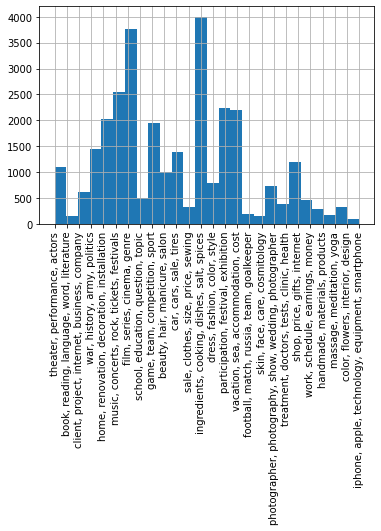

In [23]:
data['top1_interes'].hist(bins=26)
plt.xticks(rotation=90)
plt.savefig('interes_plot.pdf', bbox_inches='tight')

In [ ]:
nrmse = [0.06, 0.01, 0.06, 0.0]

In [4]:
data['Year'] = data['Year'].apply(lambda x: str(x))
data['Month'] = data['Month'].apply(lambda x: str(x))
data['Day'] = data['Day'].apply(lambda x: str(x))
data['Hour'] = data['Hour'].apply(lambda x: str(x))

In [78]:
def quantile2d(x,y,Nbins,nth):
    from numpy import percentile
    from scipy.stats import binned_statistic
    def myperc(x,n=nth):
        return(percentile(x,n))
    t=binned_statistic(x,y,statistic=myperc,bins=Nbins)
    return t

In [79]:
sample = data.loc[data['Tectonic regime'] == 'COMPRESSION']
sample.reset_index(inplace=True, drop=True)

In [80]:
sample = copy(data)

In [81]:
Nbins=5
nth=95.
y = sample['Depth'].values
x = sample['Porosity'].values
t =quantile2d(y,x,Nbins,nth)
ii=[]
for i in range(Nbins):
    ii=ii+np.argwhere(((t.binnumber==i) & (x<t.statistic[i]))).flatten().tolist()
ii=np.array(ii,dtype=int)

In [82]:
new_data = sample.loc[ii, :]
new_data.reset_index(inplace=True, drop=True)

In [83]:
name1 = 'Porosity'
name2 = 'Depth'
n = int((component(sample, [name1, name2], 'aic') + component(sample, [name1, name2], 'bic'))/2)
n

2

In [84]:
name1 = 'Porosity'
name2 = 'Depth'
n = int((component(new_data, [name1, name2], 'aic') + component(new_data, [name1, name2], 'bic'))/2)
n

3

In [85]:
colors = ["c", "m", "y", "g", "b", "r", '#d62728', "w", '#1f77b4', '#17becf']
c = random.sample(colors, n)

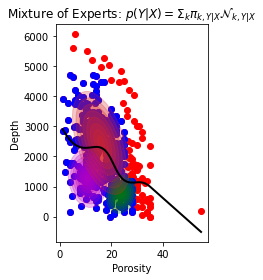

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses


random_state = check_random_state(0)

n_samples = new_data.shape[0]
X = new_data[[name1, name2]].values


X_test = np.array(sorted(sample[name1].values))
X_point = sample[[name1, name2]].values

gmm = GMM(n_components=n, random_state=0)
gmm.from_samples(X)
Y = gmm.predict(np.array([0]), X_test[:, np.newaxis])

plt.subplot(1, 2, 2)
plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
          "\mathcal{N}_{k, Y|X}$")
plt.scatter(X_point[:, 0], X_point[:, 1], c=['r'])
plt.scatter(X_point[ii, 0], X_point[ii, 1], c=['b'])
plt.xlabel(name1)
plt.ylabel(name2)
plot_error_ellipses(plt.gca(), gmm, colors=c)
plt.plot(X_test, Y.ravel(), c="k", lw=2)

plt.show()

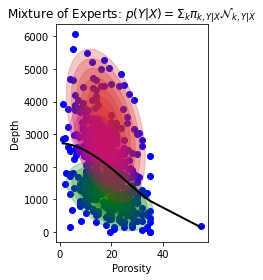

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses


random_state = check_random_state(0)

n_samples = sample.shape[0]
X = sample[[name1, name2]].values


X_test = np.array(sorted(sample[name1].values))
X_point = sample[[name1, name2]].values

gmm = GMM(n_components=n, random_state=0)
gmm.from_samples(X)
Y = gmm.predict(np.array([0]), X_test[:, np.newaxis])

plt.subplot(1, 2, 2)
plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
          "\mathcal{N}_{k, Y|X}$")
plt.scatter(X_point[:, 0], X_point[:, 1], c=['b'])
plt.xlabel(name1)
plt.ylabel(name2)
plot_error_ellipses(plt.gca(), gmm, colors=c)
plt.plot(X_test, Y.ravel(), c="k", lw=2)

plt.show()

In [5]:
node_types = get_nodes_type(data)
node_types

{'Region': 'disc',
 'Zone': 'disc',
 'Type': 'disc',
 'Year': 'disc',
 'Season': 'disc',
 'Month': 'disc',
 'Day': 'disc',
 'Hour': 'disc',
 'Latitude': 'cont',
 'Longitude': 'cont',
 'Altitude': 'cont',
 't2m': 'cont',
 'ws': 'cont',
 'wd': 'cont',
 'tp': 'cont',
 'blh': 'cont',
 'ssr': 'cont',
 'CVD60': 'cont',
 'no2': 'cont',
 'o3': 'cont',
 'so2': 'cont',
 'co': 'cont',
 'pm10': 'cont',
 'pm2.5': 'cont'}

In [6]:
node_signs = get_nodes_sign(data)
node_signs

{'Latitude': 'pos',
 'Longitude': 'neg',
 'Altitude': 'neg',
 't2m': 'pos',
 'ws': 'neg',
 'wd': 'neg',
 'tp': 'neg',
 'blh': 'neg',
 'ssr': 'neg',
 'CVD60': 'pos',
 'no2': 'neg',
 'o3': 'neg',
 'so2': 'neg',
 'co': 'pos',
 'pm10': 'pos',
 'pm2.5': 'pos'}

In [7]:
colums_for_code = []
columns_for_disc = []
for c in columns:
    if node_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)

In [8]:
data_coded, label_coder = code_categories(data, 'label', colums_for_code)
data_discrete, coder = discretization(data_coded, 'equal_frequency', columns_for_disc)

In [101]:
bn_full = structure_learning(data_discrete, 'HC', node_types, 'K2')

In [9]:
bn_full = dict()
bn_full['E'] = [['Region', 'wd'],
 ['Region', 'blh'],
 ['Region', 'CVD60'],
 ['Region', 'pm2.5'],
 ['Zone', 'no2'],
 ['Zone', 'o3'],
 ['Zone', 'so2'],
 ['Zone', 'co'],
 ['Zone', 'pm10'],
 ['Type', 'no2'],
 ['Type', 'o3'],
 ['Type', 'so2'],
 ['Type', 'co'],
 ['Type', 'pm10'],
 ['Type', 'pm2.5'],
 ['Year', 't2m'],
 ['Year', 'ws'],
 ['Year', 'wd'],
 ['Year', 'tp'],
 ['Year', 'CVD60'],
 ['Year', 'no2'],
 ['Year', 'o3'],
 ['Year', 'so2'],
 ['Year', 'co'],
 ['Year', 'pm10'],
 ['Year', 'pm2.5'],
 ['Season', 'CVD60'],
 ['Month', 't2m'],
 ['Month', 'ws'],
 ['Month', 'wd'],
 ['Month', 'tp'],
 ['Month', 'blh'],
 ['Month', 'CVD60'],
 ['Day', 'ws'],
 ['Day', 'wd'],
 ['Hour', 't2m'],
 ['Hour', 'tp'],
 ['Hour', 'blh'],
 ['Hour', 'ssr'],
 ['Latitude', 't2m'],
 ['Latitude', 'ws'],
 ['Latitude', 'ssr'],
 ['Longitude', 'ws'],
 ['Longitude', 'blh'],
 ['Longitude', 'ssr'],
 ['Altitude', 'ssr'],
 ['Altitude', 'no2'],
 ['t2m', 'ws'],
 ['t2m', 'blh'],
 ['t2m', 'ssr'],
 ['ws', 'tp'],
 ['ws', 'blh'],
 ['ws', 'ssr'],
 ['wd', 't2m'],
 ['wd', 'ws'],
 ['wd', 'blh'],
 ['wd', 'ssr'],
 ['blh', 'ssr'],
 ['blh', 'no2'],
 ['blh', 'o3'],
 ['ssr', 'tp'],
 ['no2', 'ssr'],
 ['o3', 'ssr'],
 ['o3', 'no2'],
 ['so2', 'ssr'],
 ['co', 'ssr'],
 ['co', 'no2'],
 ['co', 'so2'],
 ['pm10', 'ssr'],
 ['pm10', 'no2'],
 ['pm10', 'pm2.5']]
bn_full['V'] = columns

In [10]:
droped_edges = []
new_edges = []
nodes = []
for c in columns_for_disc:
    flag = False
    for edge in bn_full['E']:
        new_edge = []
        if (edge[1] == c) & (node_types[edge[0]] == 'disc'):
            new_edge.append(edge[0])
            new_edge.append(c + ' disc')
            new_edges.append(new_edge)
            droped_edges.append(edge)
            flag = True
    if flag == True:     
        new_edges.append([c + ' disc', c])
        bn_full['V'].append(c + ' disc')
        nodes.append(c)

In [11]:
bn_full['E'] = [l for l in bn_full['E'] if l not in droped_edges]
bn_full['E'] = bn_full['E'] + new_edges

In [12]:
for c in nodes:
    data_discrete[c] = data_discrete[c].apply(lambda x: str(x))
    data[c + ' disc'] = data_discrete[c]

In [13]:
bn_full

{'E': [['Latitude', 't2m'],
  ['Latitude', 'ws'],
  ['Latitude', 'ssr'],
  ['Longitude', 'ws'],
  ['Longitude', 'blh'],
  ['Longitude', 'ssr'],
  ['Altitude', 'ssr'],
  ['Altitude', 'no2'],
  ['t2m', 'ws'],
  ['t2m', 'blh'],
  ['t2m', 'ssr'],
  ['ws', 'tp'],
  ['ws', 'blh'],
  ['ws', 'ssr'],
  ['wd', 't2m'],
  ['wd', 'ws'],
  ['wd', 'blh'],
  ['wd', 'ssr'],
  ['blh', 'ssr'],
  ['blh', 'no2'],
  ['blh', 'o3'],
  ['ssr', 'tp'],
  ['no2', 'ssr'],
  ['o3', 'ssr'],
  ['o3', 'no2'],
  ['so2', 'ssr'],
  ['co', 'ssr'],
  ['co', 'no2'],
  ['co', 'so2'],
  ['pm10', 'ssr'],
  ['pm10', 'no2'],
  ['pm10', 'pm2.5'],
  ['Year', 't2m disc'],
  ['Month', 't2m disc'],
  ['Hour', 't2m disc'],
  ['t2m disc', 't2m'],
  ['Year', 'ws disc'],
  ['Month', 'ws disc'],
  ['Day', 'ws disc'],
  ['ws disc', 'ws'],
  ['Region', 'wd disc'],
  ['Year', 'wd disc'],
  ['Month', 'wd disc'],
  ['Day', 'wd disc'],
  ['wd disc', 'wd'],
  ['Year', 'tp disc'],
  ['Month', 'tp disc'],
  ['Hour', 'tp disc'],
  ['tp disc', 'tp']

In [13]:
for c in columns_for_disc:
    node_types[c + ' disc'] = 'disc'

In [23]:
draw_BN(bn_full, node_types, 'new_mehra')

In [14]:
params = parameter_learning(data, node_types, bn_full, 'mix')
save_structure(bn_full, 'all_net')
skel = read_structure('all_net')
save_params(params, 'all_net_param')
params = read_params('all_net_param')
all_bn = HyBayesianNetwork(skel, params)

t2m
['0']
--------------------------------------------------
t2m
['1']
--------------------------------------------------
t2m
['2']
--------------------------------------------------
t2m
['3']
--------------------------------------------------
t2m
['4']
--------------------------------------------------
ws
['0']
--------------------------------------------------
ws
['1']
--------------------------------------------------
ws
['2']
--------------------------------------------------
ws
['3']
--------------------------------------------------
ws
['4']
--------------------------------------------------
tp
['0']
--------------------------------------------------
tp
['1']
--------------------------------------------------
tp
['2']
--------------------------------------------------
tp
['3']
--------------------------------------------------
tp
['4']
--------------------------------------------------
blh
['0']
--------------------------------------------------
blh
['1']
------------------------

In [16]:
sample = data.loc[data['ssr disc'] == '4']

In [20]:
parents = []
for edge in bn_full['E']:
    if ((edge[1] == 'ssr') & (node_types[edge[0]] == 'cont')):
        parents.append(edge[0]) 

In [21]:
parents

['Latitude',
 'Longitude',
 'Altitude',
 't2m',
 'ws',
 'wd',
 'blh',
 'no2',
 'o3',
 'so2',
 'co',
 'pm10']

In [32]:
model = GaussianMixture(n_components=10, reg_covar=0.0001)
model.fit(sample[['ssr'] + parents].values)

GaussianMixture(n_components=10, reg_covar=0.0001)

In [15]:
acc, rmse_mehra, real, pred, indexes = calculate_acc(all_bn, data, columns_for_disc, 'mix', False)

In [16]:
rmse_mehra

{'Latitude': 1.12,
 'Longitude': 2.2,
 'Altitude': 87.63,
 't2m': 1.27,
 'ws': 0.79,
 'wd': 32.72,
 'tp': 0.14,
 'blh': 150.15,
 'ssr': 14717192.9,
 'CVD60': 0.02,
 'no2': 787.04,
 'o3': 5.67,
 'so2': 24109.23,
 'co': 0.18,
 'pm10': 4.02,
 'pm2.5': 0.16}

In [100]:
rmse_mehra

{'Gross': 321.56,
 'Netpay': 66.44,
 'Porosity': 2.37,
 'Permeability': 671.43,
 'Depth': 353.64}